# Coding your own RNN

Using this pre-filled notebook, we will code our own RNN for sentence classification. For now, we'll keep using IMDB, as the goal of this part is to understand how an RNN works.

Unlike our previous lab, we will also learn the embedding layer. Which means we need to deal with vocabulary by ourselves.

In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset
We load the dataset and split the training set in a stratified train/validation set.

In [2]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
   test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

((20000, 2), (5000, 2), (25000, 2))

## Vocabulary (1 point)

**\[1 point\]** Build your own vocabulary. The [example provided in torchtext documentation](https://pytorch.org/text/stable/vocab.html#id1) might be of help.
* Don't forge to setup the `min_freq` parameter to not include unfrequent noise.
* You will need a tokenizer. Reuse the `basic_english` one from the our previous lab.
* For an RNN we need two special tokens: `<unk>`, for unknown words, and `<pad>` for padding.

## Vectorize and batch the input (3 points)

As seen in class, our model should take one-hot encoded vectors corresponding to the each token vocabulary id. However, computing a vector x matrix multiplication for every input is unnecessarily costly. Multiplying a one-hot vector with a matrix is the equivalent of taking one row of the matrix. In pyTorch, we provide ids for each token which will be used as input to an `nn.Embedding` layer. The id is simply the row in the embedding matrix.

**\[1 point\]** Fill the `vectorize_text` function returning a 1D torch tensor of `torch.long` for each input text.

# Data processing

Let's reuse our preprocessing function from previous lab in order to clean the data

In [3]:
from string import punctuation
import re

def preprocess(dataset: dict) -> dict:
    '''Take a dataset, return the dataset preprocessed'''
    
    # Convert the text to lowercase and remove <br>
    dataset['text'] = dataset['text'].lower().replace('<br /><br />', '')
    
    # Replace punctuation with spaces
    dataset['text'] = re.sub('['+punctuation+']', ' ', dataset['text'])
    
    # Replace multiple with a single space
    dataset['text'] = " ".join(dataset['text'].split())
    
    return dataset

# Apply the preprocessing function to the dataset
train_df = train_df.map(preprocess)

# Take a look at the preprocessed text
train_df['text'][5]

  0%|          | 0/20000 [00:00<?, ?ex/s]

'while this is a faithful adaptation it is much less exciting than greene s novel also it s a bit ridiculous when people say things to boyer like you re spanish aren t you still the movie s not at all bad just slow moving'

In [4]:
# Let's create our vocabulary

from torchtext.vocab import vocab
from collections import Counter, OrderedDict
from itertools import chain

# Creation of our token_list

def get_token_list(documents: List) -> List :
    """
    A function to split text in documents to token list
    """
    temp_list = [text.split(" ") for text in tqdm(documents)]
    return list(chain.from_iterable(temp_list)) # We flat the list because temp_list is a list of list

token_list = get_token_list(train_df["text"])

  0%|          | 0/20000 [00:00<?, ?it/s]

In [5]:
counter = Counter(token_list)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

unk_token = '<unk>'
pad_token = '<pad>'
default_index = -1
vocabulary = vocab(ordered_dict, specials=[unk_token, pad_token], min_freq=3)
vocabulary.set_default_index(default_index)
print(vocabulary['<unk>']) #prints 0
print(vocabulary['out of vocab']) #prints -1
#make default index same as index of unk_token
vocabulary.set_default_index(vocabulary[unk_token])
vocabulary['out of vocab'] is vocabulary[unk_token] #prints True

0
-1


True

In [6]:
tokenizer = get_tokenizer("basic_english", language="en")

In [7]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabulary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    tokens = tokenizer(text)
    vectors = []
    vocab_stoi = vocabulary.get_stoi()
    for token in tokens:
        vectors.append(torch.Tensor([vocabulary[token]]))
    stacked_vectors = torch.stack(vectors)
    return stacked_vectors


In [8]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

Check the function is working correctly, especially it should return the right special id for unknown words.

In [9]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([[  49.],
        [2883.],
        [  10.],
        [ 243.],
        [ 517.],
        [  44.],
        [   0.],
        [   0.],
        [   0.],
        [   0.]])

In [10]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

To speed up the training process, we turn the inputs into batches, as we did last time. For batches to work, every line must have the same lengths. Last time, it was implicit as only a vector (the average of all embeddings) was provided. This time, every line has the length of a different review.

To go around this problem, we use padding. So every line within a batch is padded to the length of its longest element.

* **\[1 point\]** Fill the data generator function.
* **\[1 point\]** On which side should you pad and why?

In [11]:
from torch.nn.utils.rnn import pad_sequence

def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    # Create a generator
    for i in range(0, len(X), batch_size):
        X_batch = torch.stack(torch.unbind(pad_sequence(X[i:i+batch_size])))
        y_batch = torch.tensor(y[i:i+batch_size])
        yield X_batch, y_batch

In [12]:
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

#### On which side should you pad and why?

We choosed the right-padding

The main reason for right-padding is to maintain the alignment of the sequences during processing. When padding is applied to the right side, the original elements of the sequence remain unchanged and are aligned on the left side. This ensures that the meaningful information in the sequence, which usually occurs towards the beginning, is preserved without introducing any additional noise

## Classifier (3 points)

**\[3 points\]** Code your own RNN. Fill the `RNN` class correctly. Remember an RNN has 3 matrices and an embedding layer (see course slide 61).
* The embedding layer turns a one-hot vectors into dense vectors.
* The first matrix (W) connects the embedding to the hidden layer.
  * `embedding_size -> hidden_size`
* The second matrix (U) connect the previous hidden layer to the current one.
  * `hidden_size -> hidden_size`
* These to vectors are added and go through an activation function (e.g. $h_t = tanh(Wx_i+Uh_{t-1})$).
* The last matrix (V) connects the hidden layer to the hidden layer to the output.
  * `hidden_size -> 1`
* Donc forget to add an `init_hidden` function which initialize the first hidden layer to 0.

In [25]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size: int, embedding_size: int, hidden_size: int) -> None:
        """
        Initialize the RNN module.

        Args:
            input_size: The size of the input vocabulary.
            embedding_size: The size of the word embeddings.
            hidden_size: The size of the hidden layer.
        """
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.W = nn.Linear(embedding_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)
        self.activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the RNN module.

        Args:
            x: Input tensor of shape (batch_size, sequence_length).

        Returns:
            Output tensor of shape (batch_size, 1).
        """
        x = x.to(device)
        embedded = self.embedding(x.to(torch.long))
        hidden = self.init_hidden(x.size(0))
        for t in range(embedded.size(1)):
            hidden = self.activation(self.W(embedded[:, t]) + self.U(hidden))
        output = self.V(hidden)
        return output

    def init_hidden(self, batch_size: int) -> torch.Tensor:
        """
        Initialize the hidden state tensor.

        Args:
            batch_size: The size of the batch.

        Returns:
            The initialized hidden state tensor of shape (batch_size, hidden_size).
        """
        return torch.zeros(batch_size, self.W.out_features).to(device)




## Training (2 points)

Training is a bit different than usual. We will need to sequentially (but in "batch parallel") go through an input, keeping track of the hidden layer, and use the last output as prediction.

**\[2 point\]** Code the training loop.
* Note that for each batch, you need to loop through the whole input and use the output of the last token as input to your criterion.
* Keep the best model evaluated on the validation set.
* Plot the training and validation losses.
* Training will take some time (~30 min on a T4 GPU). Make sure your results appear in the notebook.

In [26]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [27]:
n_embedding = 32
n_hidden = 64
model = RNN(len(vocabulary.get_itos()), n_embedding, n_hidden).to(device)
criterion = nn.BCEWithLogitsLoss()

# Define a list of parameters
params = [torch.randn(3, 4, requires_grad=True), torch.randn(5, requires_grad=True)]

# Initialize an optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)


In [28]:
train_losses = []
valid_losses = []
n_epochs = 20

model.to(device)  # Transfer the model to the desired device

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    model.train()
    train_loss = 0.0
    train_length = 0

    for data, labels in train_gen():
        data = data.to(device)
        data = data.view(-1, n_embedding)
        data = data.permute(1, 0)
        labels = labels.to(device)
        output = model(data)

        output = output.view(-1)  # Flatten the output
        labels = labels.view(-1).float()  # Flatten the labels

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_length += 1

    train_loss /= train_length
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0.0
    valid_length = 0

    with torch.no_grad():
        for data, labels in valid_gen():
            data = data.to(device)
            data = data.view(data.size(0), -1)
            data = data.permute(1, 0)
            labels = labels.to(device)
            output = model(data)

            output = output.view(-1)  # Flatten the output
            labels = labels.view(-1).float()  # Flatten the labels

            loss = criterion(output, labels)
            valid_loss += loss.item()
            valid_length += 1

        valid_loss /= valid_length
        valid_losses.append(valid_loss)

    print(f"Epoch {epoch}/{n_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

best_model = model


Epoch 1/20, Train Loss: 0.7334, Valid Loss: 0.7300
Epoch 2/20, Train Loss: 0.7462, Valid Loss: 0.7146
Epoch 3/20, Train Loss: 0.7171, Valid Loss: 0.7258
Epoch 4/20, Train Loss: 0.7249, Valid Loss: 0.7291
Epoch 5/20, Train Loss: 0.7284, Valid Loss: 0.7115
Epoch 6/20, Train Loss: 0.7328, Valid Loss: 0.7609
Epoch 7/20, Train Loss: 0.7346, Valid Loss: 0.7603
Epoch 8/20, Train Loss: 0.7330, Valid Loss: 0.7362
Epoch 9/20, Train Loss: 0.7239, Valid Loss: 0.7193
Epoch 10/20, Train Loss: 0.7176, Valid Loss: 0.7201
Epoch 11/20, Train Loss: 0.7196, Valid Loss: 0.7111
Epoch 12/20, Train Loss: 0.7222, Valid Loss: 0.7157
Epoch 13/20, Train Loss: 0.7146, Valid Loss: 0.7381
Epoch 14/20, Train Loss: 0.7277, Valid Loss: 0.7447
Epoch 15/20, Train Loss: 0.7372, Valid Loss: 0.7165
Epoch 16/20, Train Loss: 0.7350, Valid Loss: 0.7102
Epoch 17/20, Train Loss: 0.7241, Valid Loss: 0.7387
Epoch 18/20, Train Loss: nan, Valid Loss: nan
Epoch 19/20, Train Loss: nan, Valid Loss: nan
Epoch 20/20, Train Loss: nan, Val

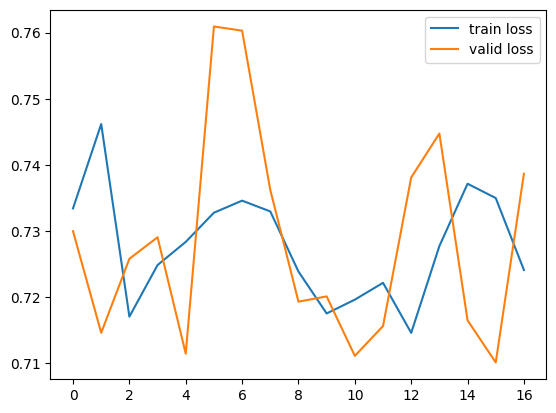

In [29]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

## Evaluation (1 point)

* **\[1 point\]** Compute the accuracy for all 3 splits.

In [45]:
def accuracy(model: nn.Module, data: torch.utils.data.Dataset) -> float:
    """Calculates the accuracy of a model on a data set.

    Args:
        model: The model to be evaluated.
        data: The data set to be evaluated on.

    Returns:
        The accuracy of the model on the data set.
    """

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, label in data():
            data = data.to(device)
            data = data.view(data.size(0), -1)
            data = data.permute(1,0)
            label = label.to(device)
            outputs = model(data)


            outputs = outputs.view(-1)  # Flatten the output
            label = label.view(-1).float()  # Flatten the labelss

            # Get the prediction
            predictions = outputs.argmax(dim=0)

            # Count the number of correct predictions
            correct += (predictions == label).sum().item()

            total += len(label)

    return correct / total

# Evaluate the model on the training set
train_accuracy = accuracy(best_model, train_gen)

# Evaluate the model on the validation set
valid_accuracy = accuracy(best_model, valid_gen)

# Evaluate the model on the test set
test_accuracy = accuracy(best_model, test_gen)

print("Training accuracy:", train_accuracy)
print("Validation accuracy:", valid_accuracy)
print("Test accuracy:", test_accuracy)

Training accuracy: 0.5003
Validation accuracy: 0.4988
Test accuracy: 0.5
